In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
directory = "/content/drive/MyDrive/asl_dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


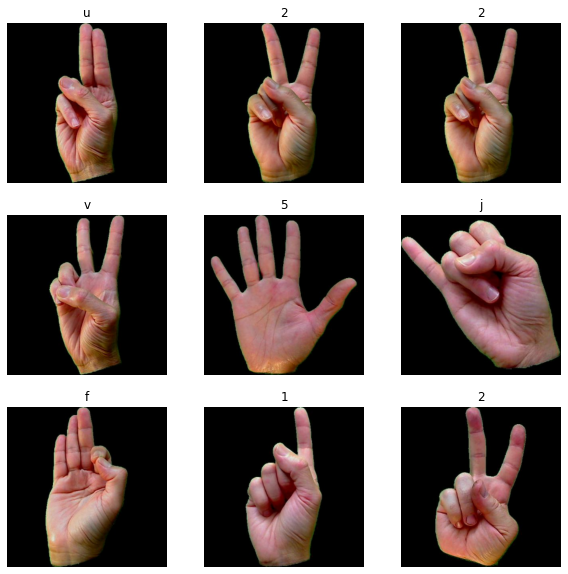

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

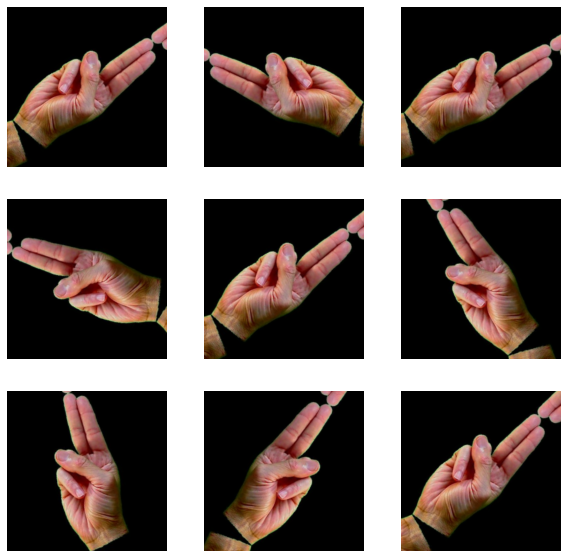

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape = IMG_SHAPE,
                                                     include_top=True,
                                                     weights='imagenet')

91897856/91884032 [==============================] - 2s 0us/step


In [9]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

avg_pool
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [12]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.xception.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n03840681', 'ocarina', 0.13497381), ('n03494278', 'harmonica', 0.0428281)],
 [('n02786058', 'Band_Aid', 0.12667274),
  ('n01728572', 'thunder_snake', 0.08169409)],
 [('n02786058', 'Band_Aid', 0.17335151), ('n04005630', 'prison', 0.05199732)],
 [('n02786058', 'Band_Aid', 0.33585277), ('n04423845', 'thimble', 0.03412212)],
 [('n02786058', 'Band_Aid', 0.10046099), ('n03929660', 'pick', 0.062123414)],
 [('n02786058', 'Band_Aid', 0.074781224), ('n03627232', 'knot', 0.06946436)],
 [('n02786058', 'Band_Aid', 0.07371045),
  ('n03535780', 'horizontal_bar', 0.07203533)],
 [('n02786058', 'Band_Aid', 0.26195845), ('n03929660', 'pick', 0.04681731)],
 [('n02786058', 'Band_Aid', 0.10333341), ('n03929660', 'pick', 0.08327891)],
 [('n02786058', 'Band_Aid', 0.7945473), ('n04423845', 'thimble', 0.021069786)],
 [('n02786058', 'Band_Aid', 0.25976303),
  ('n03485794', 'handkerchief', 0.11373761)],
 [('n02786058', 'Band_Aid', 0.48618123),
  ('n04423845', 'thimble', 0.037402865)],
 [('n02786058', 'Band_Ai

In [13]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.xception.Xception(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.GlobalAveragePooling2D()(x)
  
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [14]:
model = asl_model(IMG_SIZE, data_augmentation)

83697664/83683744 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [16]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [18]:
initial_epochs = 50
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 689s 12s/step - loss: 3.0481 - accuracy: 0.2288 - val_loss: 2.8081 - val_accuracy: 0.2719
Epoch 2/50
56/56 [==============================] - 23s 407ms/step - loss: 2.3152 - accuracy: 0.4537 - val_loss: 2.3755 - val_accuracy: 0.4164
Epoch 3/50
56/56 [==============================] - 22s 389ms/step - loss: 1.9095 - accuracy: 0.5622 - val_loss: 2.1244 - val_accuracy: 0.3926
Epoch 4/50
56/56 [==============================] - 23s 401ms/step - loss: 1.6683 - accuracy: 0.6093 - val_loss: 1.9427 - val_accuracy: 0.4390
Epoch 5/50
56/56 [==============================] - 23s 398ms/step - loss: 1.4760 - accuracy: 0.6633 - val_loss: 1.7686 - val_accuracy: 0.5318
Epoch 6/50
56/56 [==============================] - 22s 382ms/step - loss: 1.3185 - accuracy: 0.7030 - val_loss: 1.6680 - val_accuracy: 0.5438
Epoch 7/50
56/56 [==============================] - 23s 400ms/step - loss: 1.2365 - accuracy: 0.7064 - val_loss: 1.5849 - val_accuracy: 0.5650


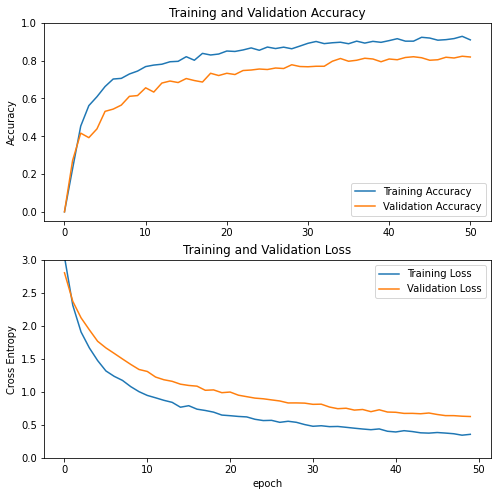

Highest Accuracy: 92.90176033973694%
Highest Validation Accuracy: 82.36074447631836%


In [19]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

In [20]:
model.save('/content/drive/MyDrive/Xception')